<a href="https://colab.research.google.com/github/AxlSyr/ArtificialIntelligenceUAEM/blob/master/AventuraPokemon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Reynoso Gomez Luis Alfredo** - 10018748

**Reyes Flores Axel** - 10018747

# EDA Pokemon y algo más...

In [1]:
# Data manipulation libraries
import numpy as np 
import pandas as pd 

# Data visualisation 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Web scraping 
from bs4 import BeautifulSoup, Comment
from requests import get

## Reading the data
pokemon = pd.read_csv('Pokemon.csv')


### Datos - Preparación y Limpieza

Algo de exploración básica...


In [2]:
print(pokemon.head())
print(pokemon.info())

   #                   Name Type 1  ... Speed  Generation  Legendary
0  1              Bulbasaur  Grass  ...    45           1      False
1  2                Ivysaur  Grass  ...    60           1      False
2  3               Venusaur  Grass  ...    80           1      False
3  3  VenusaurMega Venusaur  Grass  ...    80           1      False
4  4             Charmander   Fire  ...    65           1      False

[5 rows x 13 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     8

In [3]:
pokemon

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,719,Diancie,Rock,Fairy,600,50,100,150,100,150,50,6,True
796,719,DiancieMega Diancie,Rock,Fairy,700,50,160,110,160,110,110,6,True
797,720,HoopaHoopa Confined,Psychic,Ghost,600,80,110,60,150,130,70,6,True
798,720,HoopaHoopa Unbound,Psychic,Dark,680,80,160,60,170,130,80,6,True


In [4]:
# Desechar #
pokemon.drop(['#'], axis = 'columns', inplace = True)

# Mau: Sólo trabajaremos con la generación 1 y 2 .... vean que en este dataset hay hasta la 6ta gen...
# Nosotros trabajaremos con la generación 3 y 4
my_pokemon = pokemon[pokemon.Generation.isin([3, 4])].copy()
my_pokemon.Generation.unique()
my_pokemon.shape

(281, 12)

In [5]:
print('There are ',my_pokemon.duplicated('Name').sum(), 'duplicated names in the dataset, so it must be something else\n')
print(my_pokemon.loc[(my_pokemon.Generation == 3) & (my_pokemon.Legendary == True), 'Name'],  '''\nAha! We didn't have MEGA stuff back in my day. Let's exclude those\n''')

There are  0 duplicated names in the dataset, so it must be something else

414                 Regirock
415                   Regice
416                Registeel
417                   Latias
418        LatiasMega Latias
419                   Latios
420        LatiosMega Latios
421                   Kyogre
422      KyogrePrimal Kyogre
423                  Groudon
424    GroudonPrimal Groudon
425                 Rayquaza
426    RayquazaMega Rayquaza
427                  Jirachi
428       DeoxysNormal Forme
429       DeoxysAttack Forme
430      DeoxysDefense Forme
431        DeoxysSpeed Forme
Name: Name, dtype: object 
Aha! We didn't have MEGA stuff back in my day. Let's exclude those



In [6]:
mega_filter = (my_pokemon.Name.str.contains('Mega ')) #Put a space there to exclude meganium which is a legit second generation pokemon
my_pokemon = my_pokemon[~mega_filter]
print(my_pokemon.groupby('Generation').size(),  '\nOk now everything matches my expectations!')

Generation
3    140
4    116
dtype: int64 
Ok now everything matches my expectations!


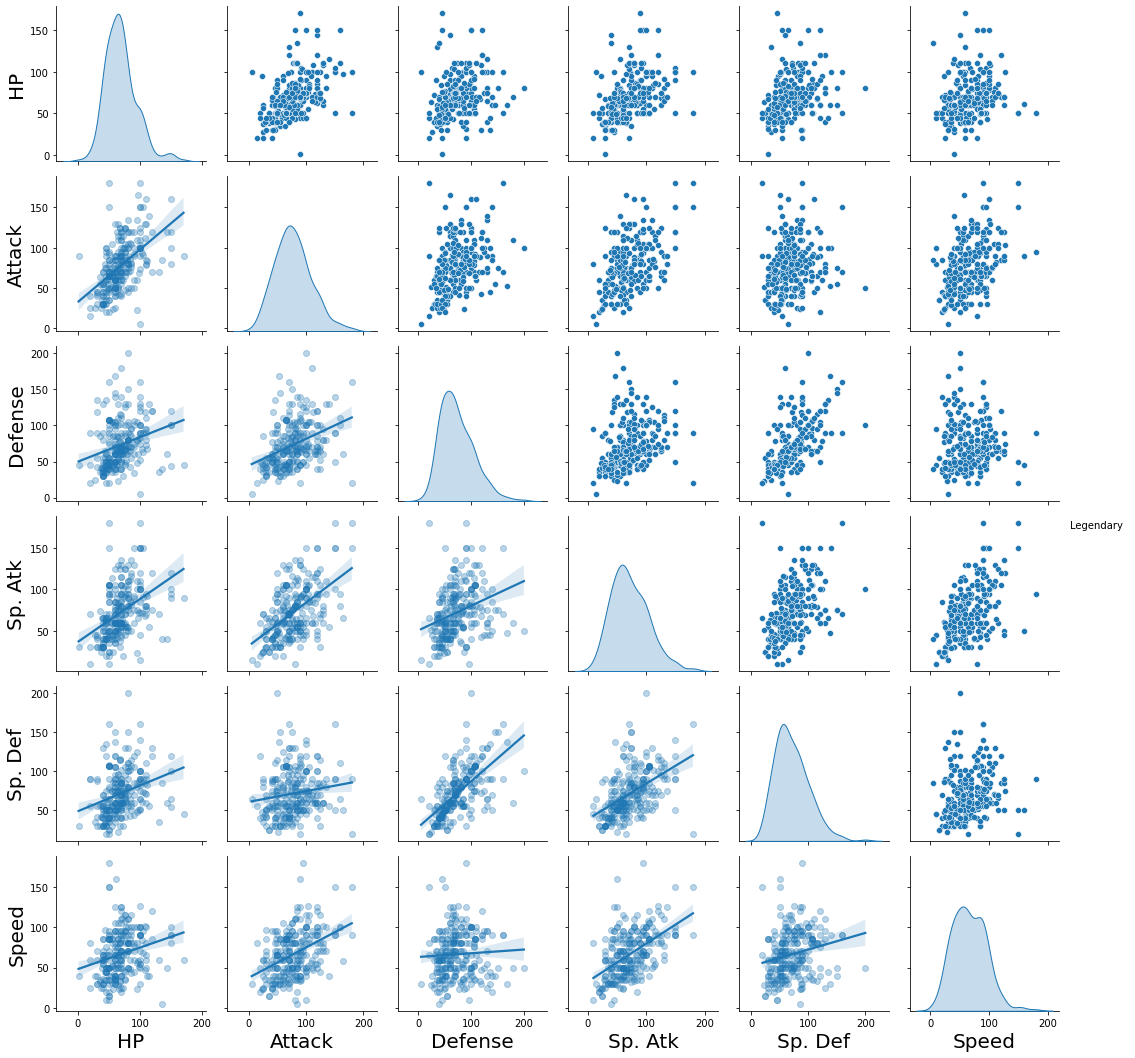

In [7]:
def my_pairgrid(input_df):
    mpl.rcParams["axes.labelsize"] = 20 #Increases the axis titles and the legend size
    g = sns.PairGrid(input_df, vars=['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed'])
    g = g.map_diag(sns.kdeplot, shade=True)
    g = g.map_lower(sns.regplot, scatter_kws={'alpha':0.3})
    g.hue_vals = input_df["Legendary"]
    g.hue_names = input_df["Legendary"].unique()
    g.palette = sns.color_palette("Set2", len(g.hue_names))
    g = g.map_upper(sns.scatterplot).add_legend(title='Legendary', fontsize= 14)
    return(g)
_ = my_pairgrid(my_pokemon)

In [8]:
my_pokemon

,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
272,Treecko,Grass,NaN,310,40,45,35,65,55,70,3,False
273,Grovyle,Grass,NaN,405,50,65,45,85,65,95,3,False
274,Sceptile,Grass,NaN,530,70,85,65,105,85,120,3,False
276,Torchic,Fire,NaN,310,45,60,40,70,50,45,3,False
277,Combusken,Fire,Fighting,405,60,85,60,85,60,55,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...
548,Manaphy,Water,NaN,600,100,100,100,100,100,100,4,False
549,Darkrai,Dark,NaN,600,70,90,90,135,90,125,4,True
550,ShayminLand Forme,Grass,NaN,600,100,100,100,100,100,100,4,True
551,ShayminSky Forme,Grass,Flying,600,100,103,75,120,75,127,4,True


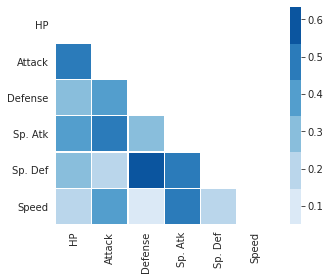

In [9]:
my_corr = my_pokemon.loc[:, 'HP':'Speed'].corr() 
mask = np.zeros_like(my_corr) 
mask[np.triu_indices_from(mask)] = True ## This part is to blank out the upper diagonal
with sns.axes_style("white"):
     ax = sns.heatmap(my_corr, mask=mask, square=True, cmap=sns.color_palette("Blues"), vmax=np.max(np.sort(my_corr.values)[:,-2]), linewidths=0.3)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning:

6.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



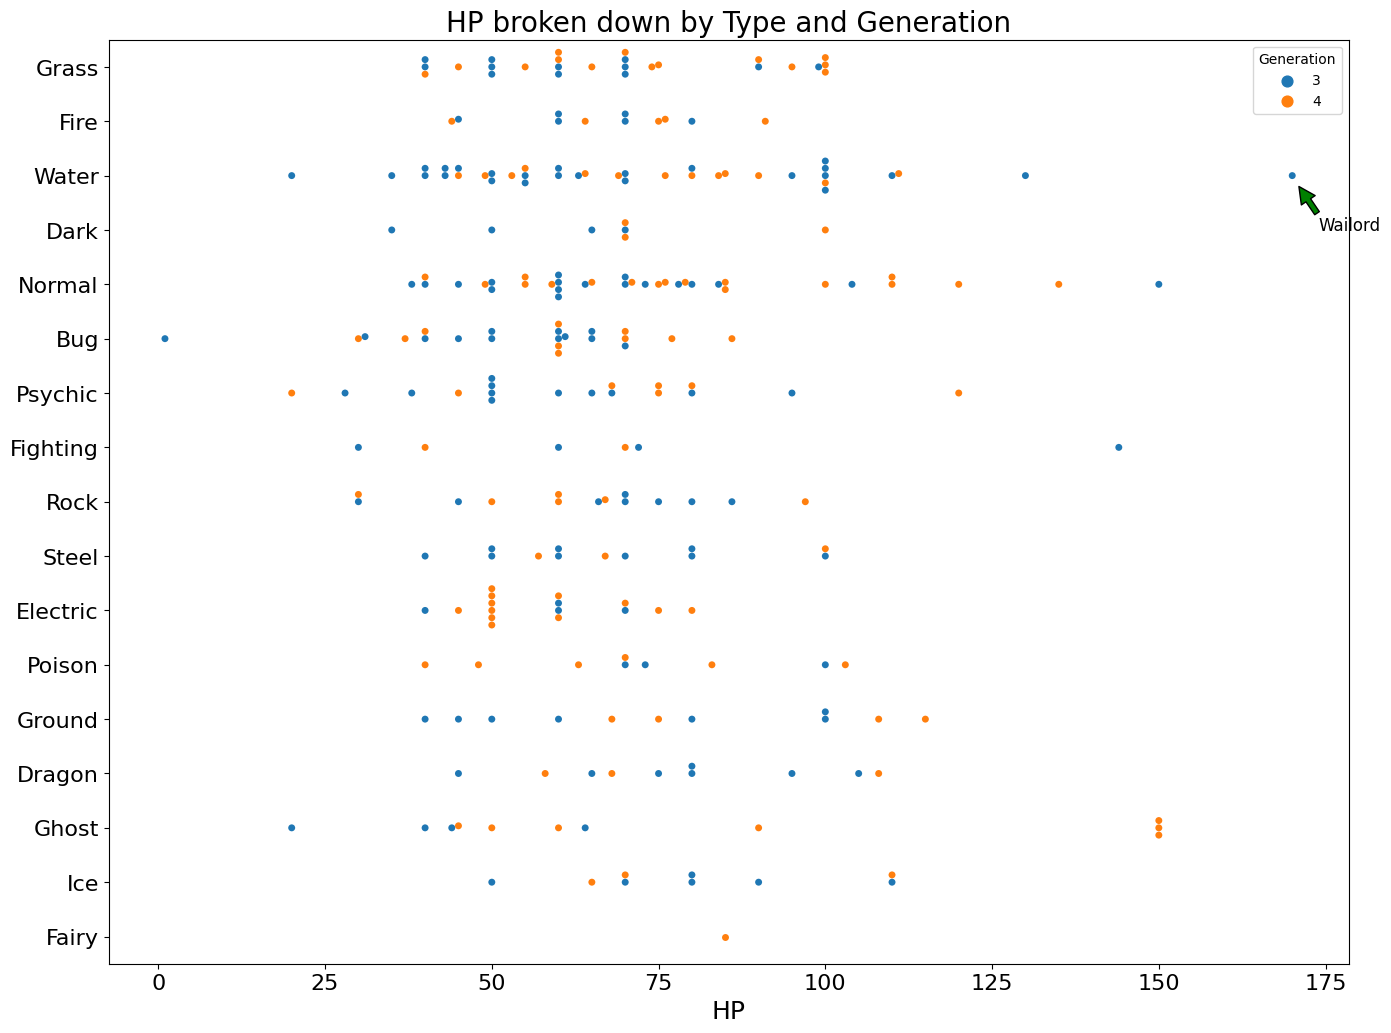

In [10]:
sns.reset_defaults()
plt.figure(figsize=(16,12))
g = sns.swarmplot(x='HP', y='Type 1', hue = 'Generation', data=my_pokemon)
g.yaxis.label.set_visible(False)
g.set_title('HP broken down by Type and Generation')
_ = g.annotate('Wailord', xy=(171, 2.2), xytext = (174, 3), fontsize = 12, arrowprops=dict(facecolor='green'))
g.title.set_fontsize(20)
g.xaxis.label.set_fontsize(18)
g.tick_params(axis='x', labelsize=16)
g.tick_params(axis='y', labelsize=16)

In [11]:
my_pokemon.loc[my_pokemon['Type 1'] == "Fairy", 'Type 1'] = 'Normal'
my_pokemon.loc[my_pokemon['Type 2'] == "Fairy", 'Type 2'] = np.nan

In [12]:
def attr_per_type(input_df, y_attr, hue_attr):
    mpl.rcParams["font.size"] = 18
    f, axes = plt.subplots(2, 3, figsize=(20, 20), sharey=True, sharex=True)
    #f.tight_layout()
    poke_attributes = ['HP', 'Defense', 'Sp. Def', 'Speed', 'Attack', 'Sp. Atk']
    counter = 0
    #axes[0,1].tick_params(labelleft=False)
    for row in range(2):
        for col in range(3):
            sns.boxplot(y = y_attr, x = poke_attributes[counter], data=input_df, ax=axes[row, col], showfliers=False)
            sns.swarmplot(y = y_attr, x = poke_attributes[counter], data=input_df, ax=axes[row, col], hue = hue_attr, palette=['black', 'orange'])
            axes[row, col].set_title(axes[row, col].get_xlabel())
            axes[row, col].xaxis.label.set_visible(False)
            axes[row, col].get_legend().remove()
            counter += 1
            if (col == 0):
                axes[row, col].yaxis.label.set_visible(False)
                continue
            axes[row, col].yaxis.set_visible(False)
    return(f, axes)


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning:

6.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning:

5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning:

5.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning:

6.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning:

6.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



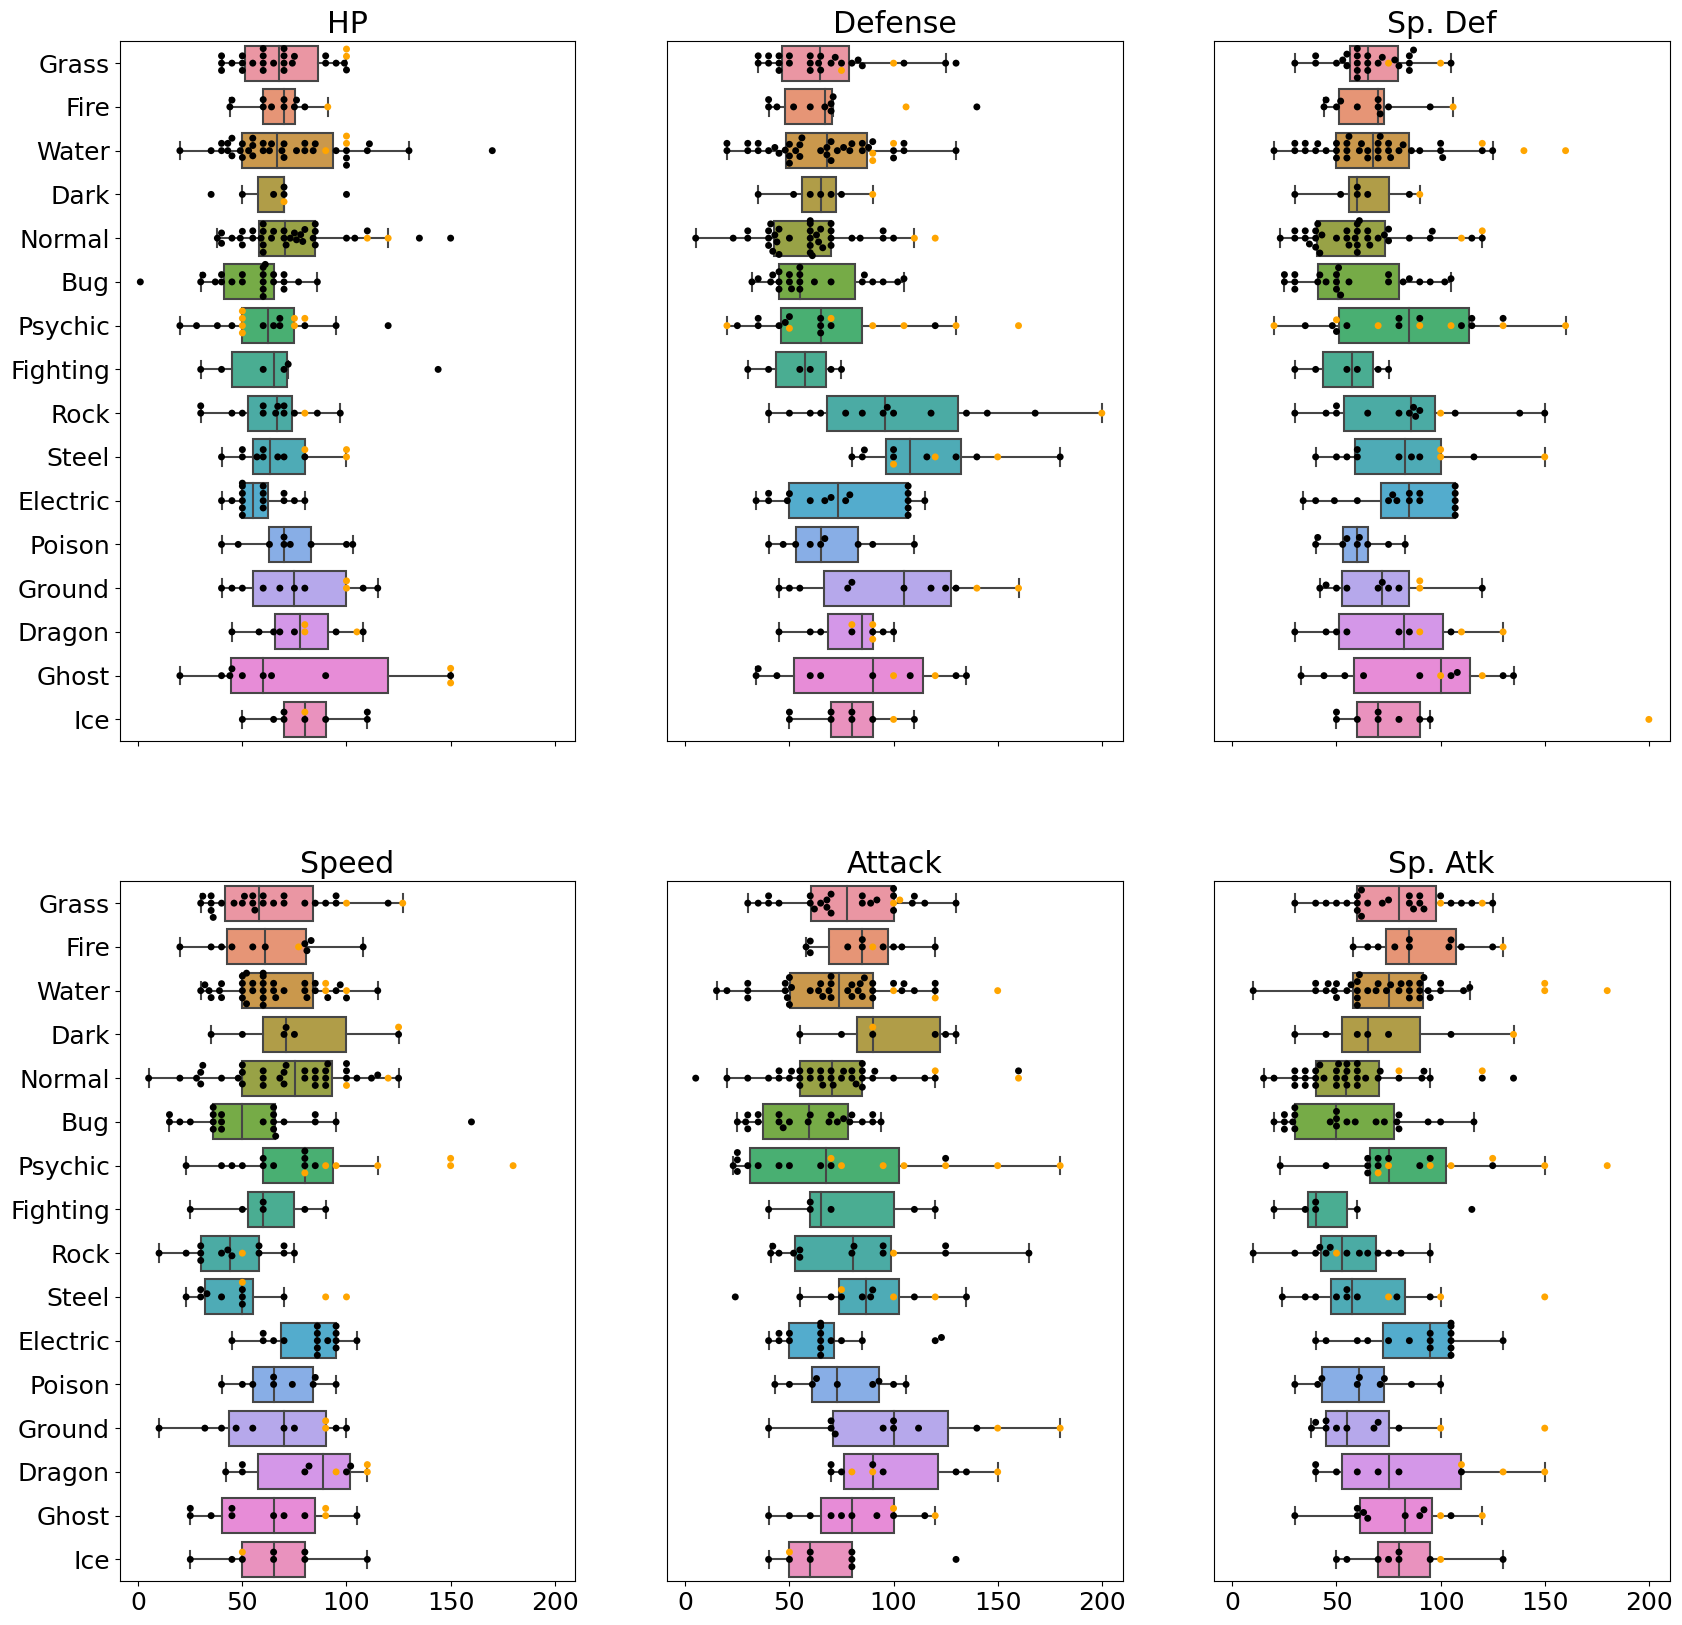

In [13]:
(f, axes) = attr_per_type(my_pokemon, 'Type 1', 'Legendary')

In [14]:
poke_url = 'https://pokemondb.net/evolution#evo-g3'
response = get(poke_url) 
html_soup = BeautifulSoup(response.text, 'html.parser') ## Getting the html into python

In [15]:
infocard = html_soup.find_all('div', {'class' : 'infocard-list-evo'})

In [16]:
raw = []
for chain in infocard:
    raw.append(([(i, x.find('small').getText(), x.find_all('small')[1].getText(), x.find('a', {'class':'ent-name'}).getText(), ) for i, x in enumerate(list(chain.find_all('span', {'class':'infocard-lg-data text-muted'})), 1)]))

raw[:4] ## Our list contains touple lists with the evolution branch of each pokemon. We keep that in mind for our future processing

[[(1, '#001', 'Grass · Poison', 'Bulbasaur'),
  (2, '#002', 'Grass · Poison', 'Ivysaur'),
  (3, '#003', 'Grass · Poison', 'Venusaur')],
 [(1, '#004', 'Fire', 'Charmander'),
  (2, '#005', 'Fire', 'Charmeleon'),
  (3, '#006', 'Fire · Flying', 'Charizard')],
 [(1, '#007', 'Water', 'Squirtle'),
  (2, '#008', 'Water', 'Wartortle'),
  (3, '#009', 'Water', 'Blastoise')],
 [(1, '#010', 'Bug', 'Caterpie'),
  (2, '#011', 'Bug', 'Metapod'),
  (3, '#012', 'Bug · Flying', 'Butterfree')]]

In [17]:
raw

[[(1, '#001', 'Grass · Poison', 'Bulbasaur'),
  (2, '#002', 'Grass · Poison', 'Ivysaur'),
  (3, '#003', 'Grass · Poison', 'Venusaur')],
 [(1, '#004', 'Fire', 'Charmander'),
  (2, '#005', 'Fire', 'Charmeleon'),
  (3, '#006', 'Fire · Flying', 'Charizard')],
 [(1, '#007', 'Water', 'Squirtle'),
  (2, '#008', 'Water', 'Wartortle'),
  (3, '#009', 'Water', 'Blastoise')],
 [(1, '#010', 'Bug', 'Caterpie'),
  (2, '#011', 'Bug', 'Metapod'),
  (3, '#012', 'Bug · Flying', 'Butterfree')],
 [(1, '#013', 'Bug · Poison', 'Weedle'),
  (2, '#014', 'Bug · Poison', 'Kakuna'),
  (3, '#015', 'Bug · Poison', 'Beedrill')],
 [(1, '#016', 'Normal · Flying', 'Pidgey'),
  (2, '#017', 'Normal · Flying', 'Pidgeotto'),
  (3, '#018', 'Normal · Flying', 'Pidgeot')],
 [(1, '#019', 'Normal', 'Rattata'), (2, '#020', 'Normal', 'Raticate')],
 [(1, '#019', 'Alolan Rattata', 'Rattata'),
  (2, '#020', 'Alolan Raticate', 'Raticate')],
 [(1, '#021', 'Normal · Flying', 'Spearow'),
  (2, '#022', 'Normal · Flying', 'Fearow')],
 [(1

In [18]:
step_1 = [[elem for elem in branch_list if 'Alol' not in elem[2]] for branch_list in raw]
step_2 = [[elem for elem in branch_list if (int(elem[1][1:]) > 251 and int(elem[1][1:]) < 494)] for branch_list in step_1]
step_3 = [elem for elem in step_2 if len(elem) > 1]

In [19]:
has_evolution = [[elem[3] for elem in branch_list] for branch_list in step_3] ## Extract all pokemon that in the raw list
has_evolution = sum(has_evolution, []) ## 'Un-tupple' them -- This is not the optimal way to do this but I find it really really cool and for such a small list it doesn't matter

In [20]:
last_evolutions  = [x[-1] for x in step_3] ## Take the last entry into each element list
last_evolutions.extend([x[-2] for x in step_3 if x[-1][0] == 4]) # The ones that have 2 end evolutions like Politoed and Poliwrath

## This is the eevee and hitmontop section as they have 5 and 3 final evolutions respecitvely
eevee_and_hitmon = [x[1:] for x in step_3 if (x[0][3] == 'Tyrogue') or (x[0][3] ==  'Eevee')]
eevee_and_hitmon = sum(eevee_and_hitmon, [])
last_evolutions.extend(eevee_and_hitmon)

last_evo_df = pd.DataFrame([[int(x[1][1:]), x[3]] for x in last_evolutions], columns=['Number', 'Pokemon'] )
last_evo_df = last_evo_df.drop_duplicates() ## Remove duplicates because some hitmontop and eevee evolutions have been added more than once in the process

In [21]:
my_pokemon['Has_evol'] = my_pokemon.Name.isin(has_evolution)
my_pokemon['Last_evol'] = my_pokemon.Name.isin(last_evo_df.Pokemon)
my_evolved_pokemon = my_pokemon.loc[(my_pokemon.Last_evol == True) | (my_pokemon.Has_evol == False)].copy()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning:

7.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning:

7.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning:

7.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



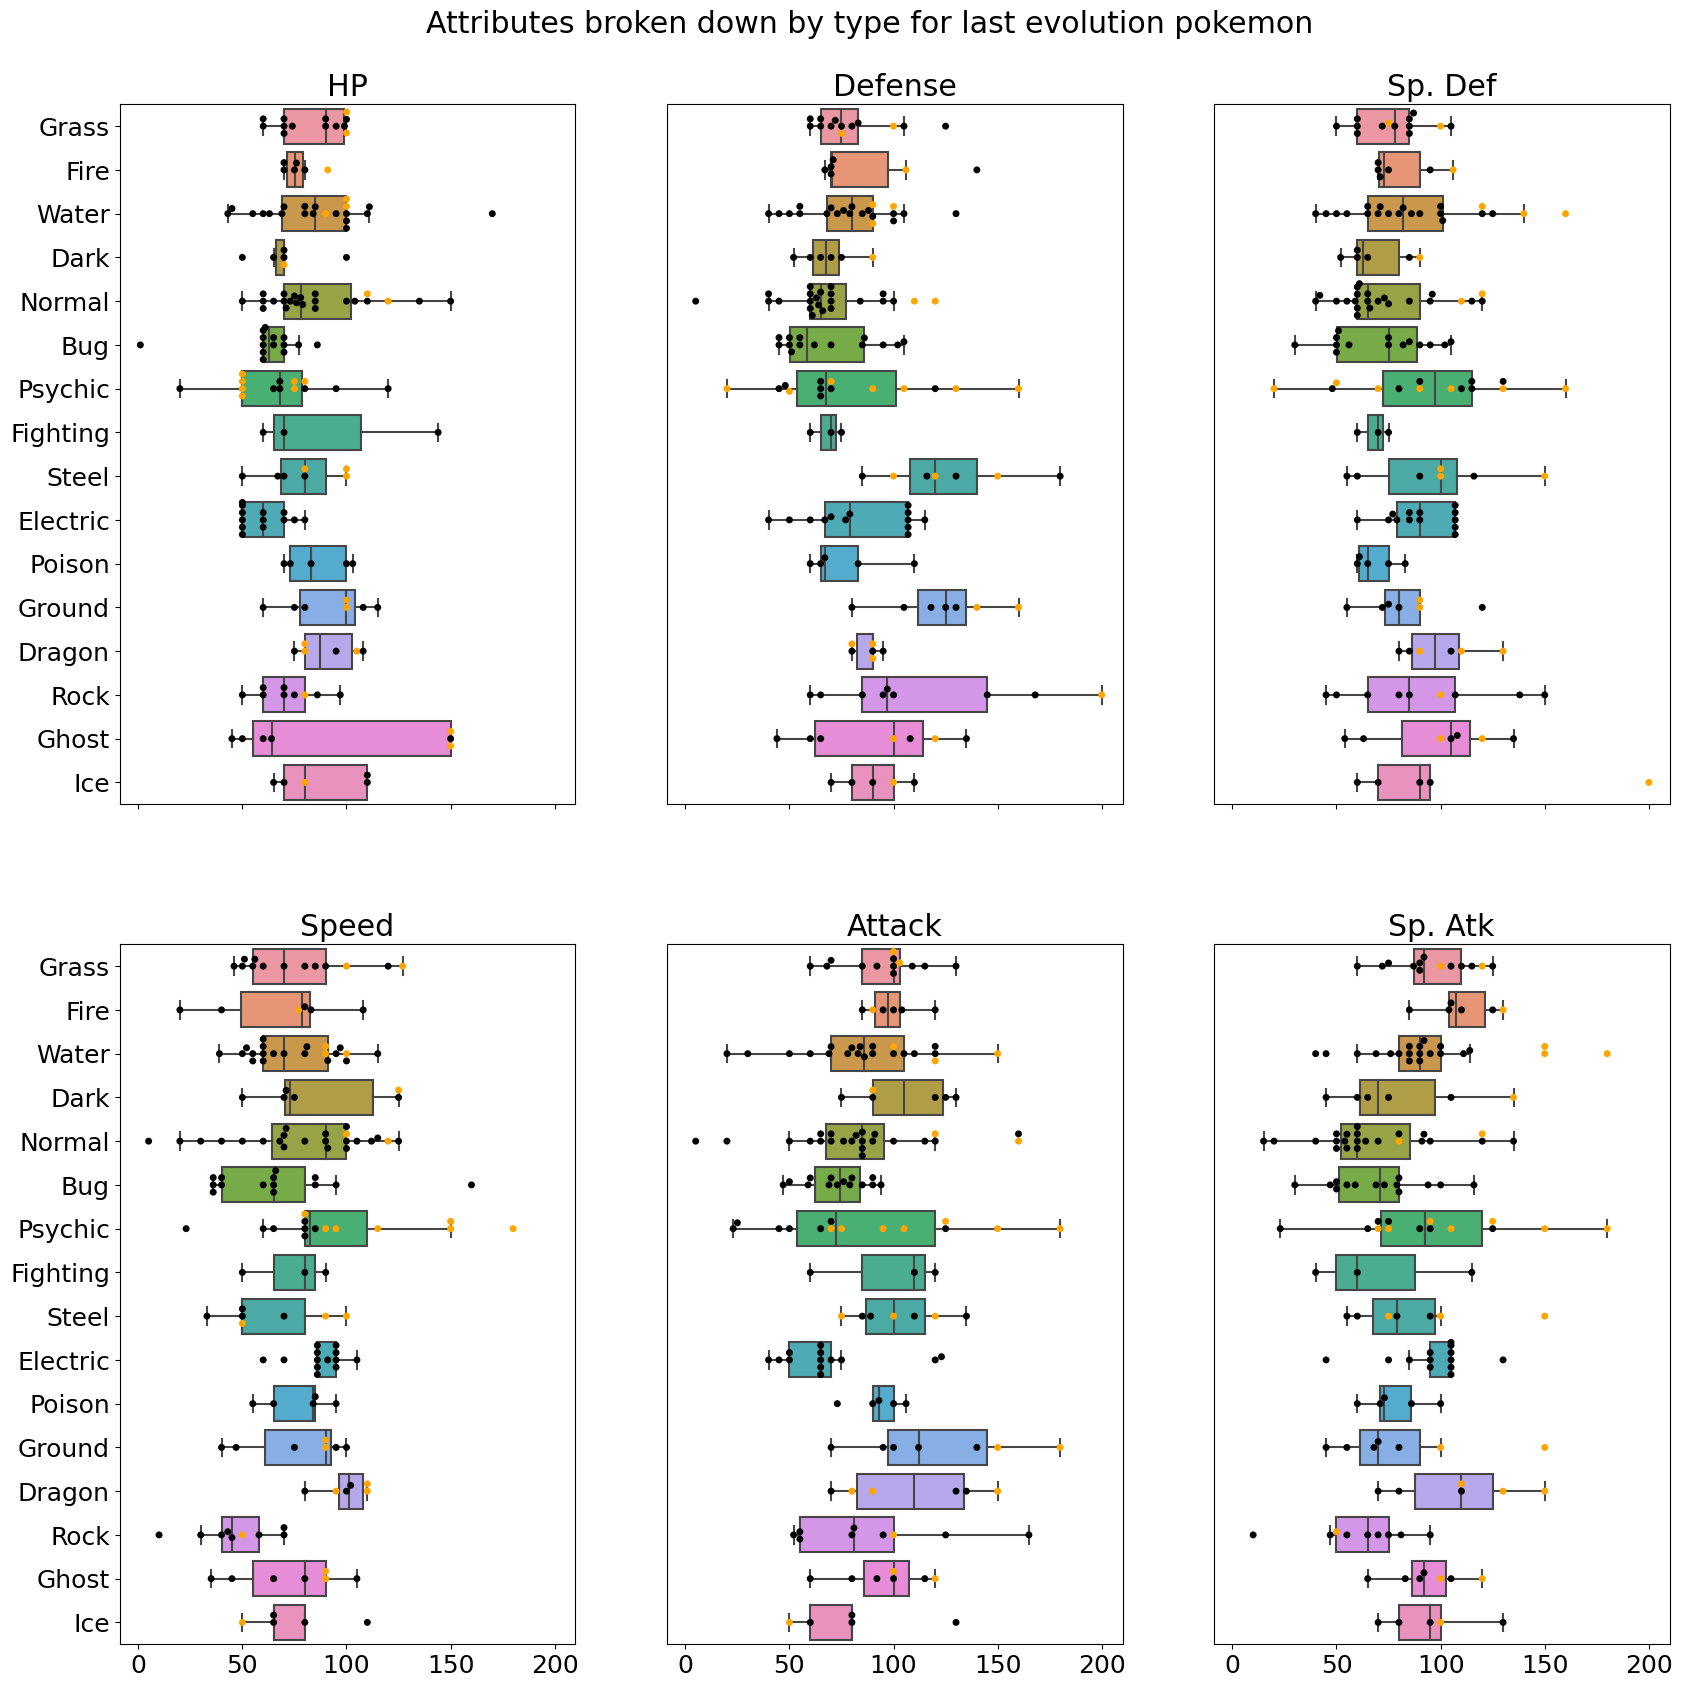

In [22]:
(f, axes) = attr_per_type(my_evolved_pokemon, 'Type 1', 'Legendary')
_ = f.suptitle('Attributes broken down by type for last evolution pokemon', va='center', y=0.92)

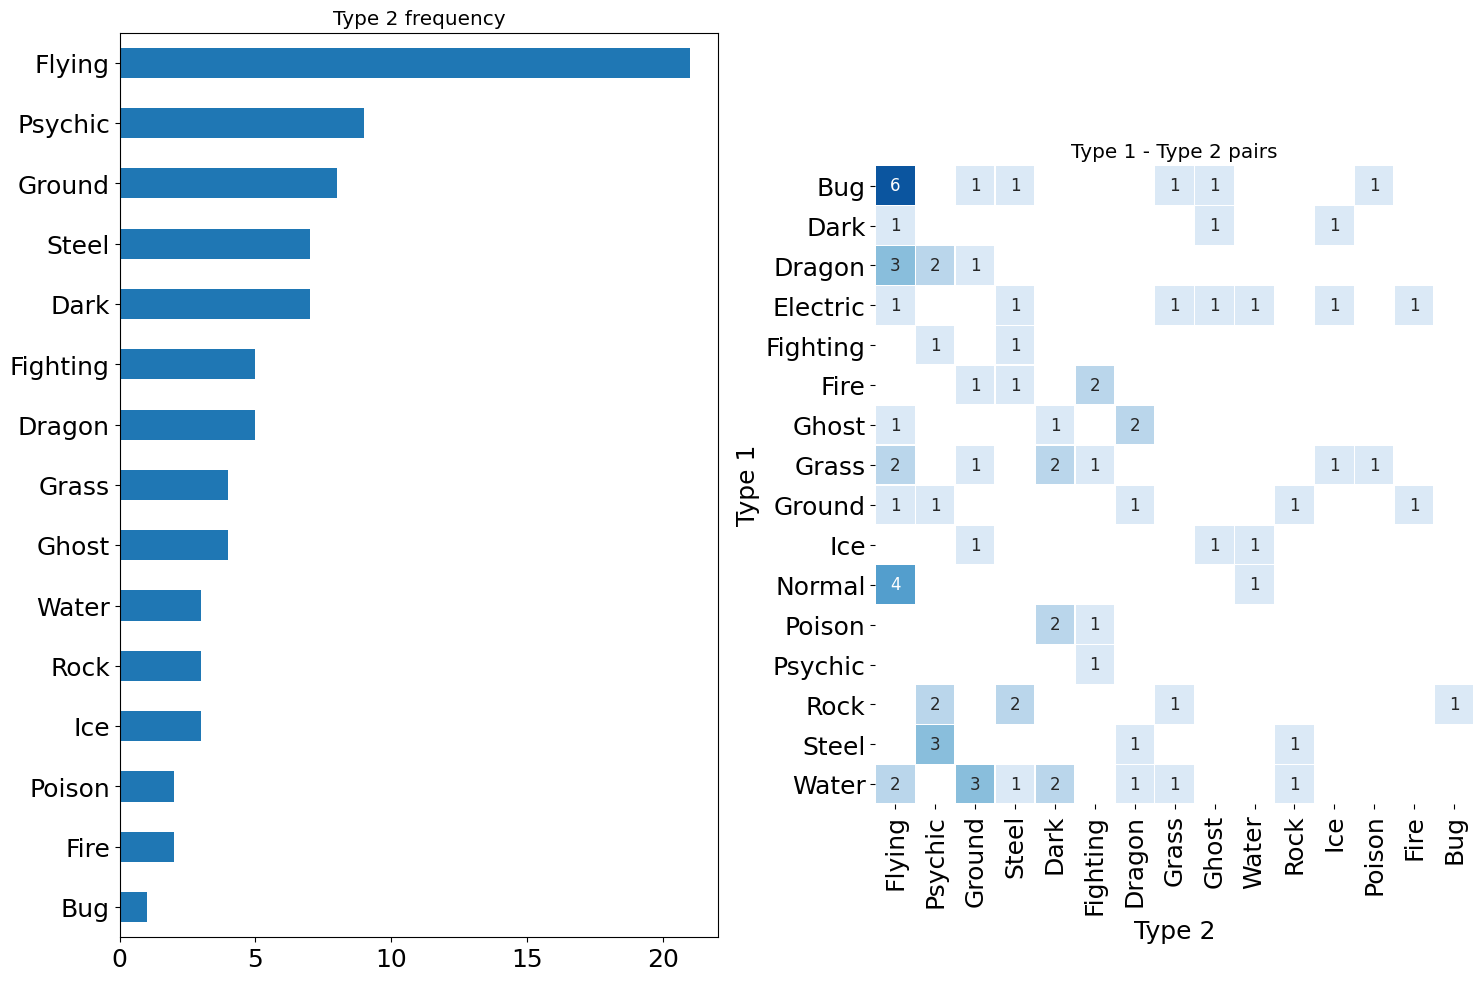

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
mpl.rcParams["font.size"] = 12

ax1 = my_evolved_pokemon.groupby('Type 2').size().sort_values().plot(kind='barh', ax=ax1)
start, end = ax1.get_xlim()
ax1.xaxis.set_ticks(np.arange(start, end, 5))
ax1.axes.get_yaxis().get_label().set_visible(False)
_ = ax1.set_title('Type 2 frequency')

pivot_dat = my_evolved_pokemon.pivot_table(index='Type 1', columns='Type 2', aggfunc = 'size')
pivot_dat = pivot_dat[pivot_dat.sum().sort_values(ascending = False).index] #Reordering
ax2 = sns.heatmap(pivot_dat, annot=True, square=True, cmap=sns.color_palette("Blues"), cbar=False, linewidths=0.3, ax=ax2)
_ = ax2.set_title('Type 1 - Type 2 pairs')
fig.tight_layout()

In [24]:
my_evolved_pokemon['New type'] = my_evolved_pokemon['Type 1']
my_evolved_pokemon['Dual type'] = ~pd.isnull(my_pokemon['Type 2'])
dual_evolved_pokemon = my_evolved_pokemon.append(my_evolved_pokemon[my_evolved_pokemon['Dual type']==True], ignore_index=True)

#Change the second instance of the pokemon to have the second type
dual_evolved_pokemon.loc[dual_evolved_pokemon.duplicated(), 'New type'] = dual_evolved_pokemon.loc[dual_evolved_pokemon.duplicated(), 'Type 2'] 

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning:

7.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning:

6.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning:

7.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



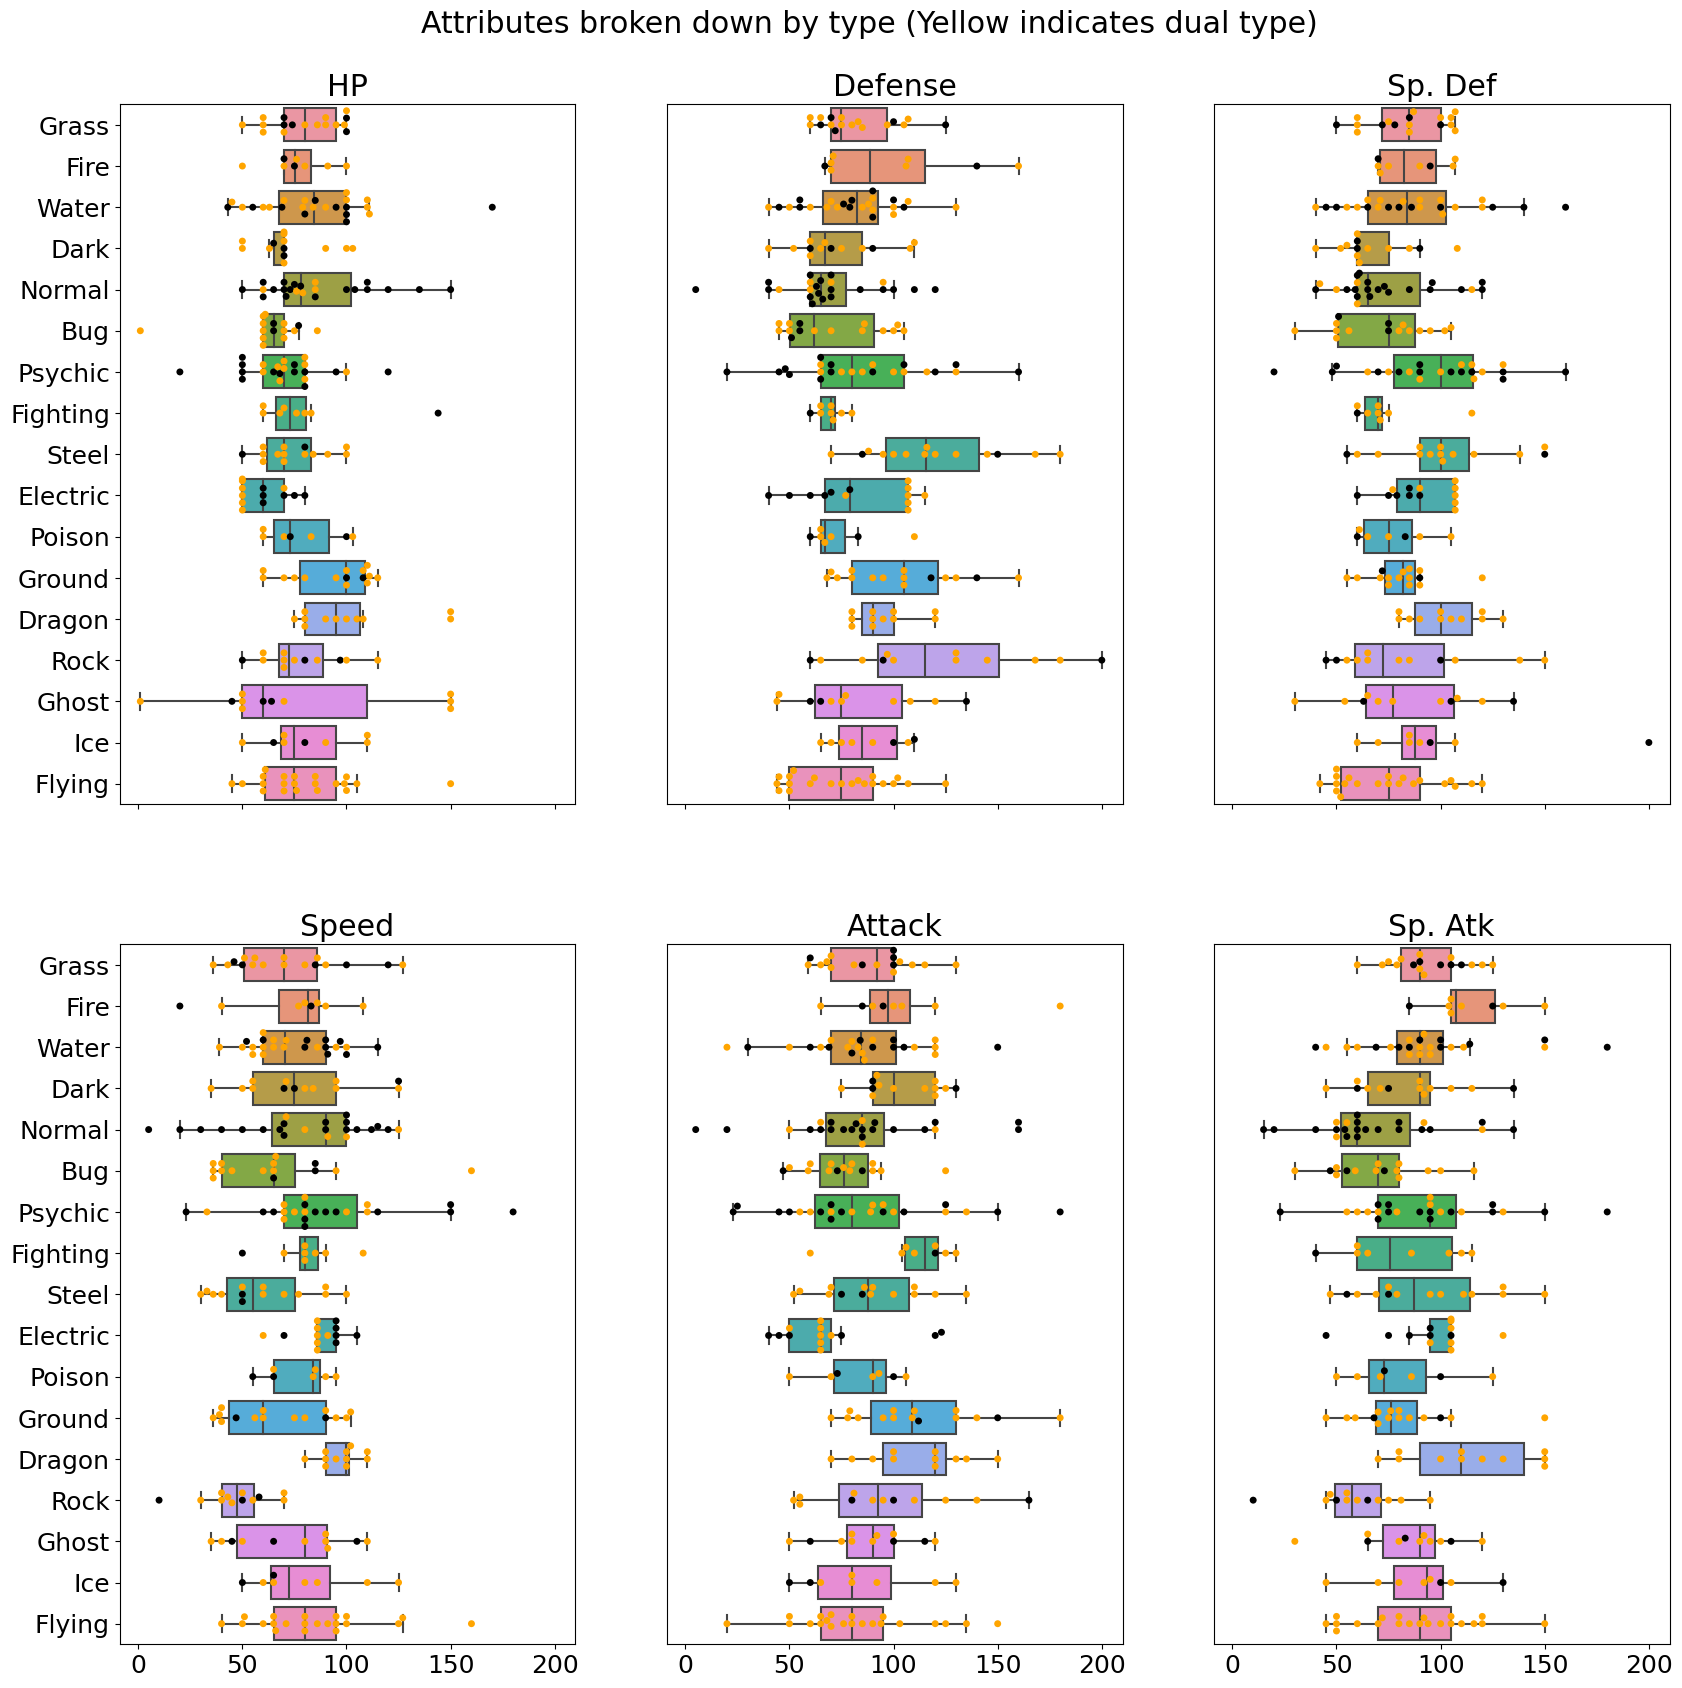

In [25]:
(f, axes) = attr_per_type(dual_evolved_pokemon, 'New type', 'Dual type')
_ = f.suptitle("Attributes broken down by type (Yellow indicates dual type)", va='center', y=0.92)

In [26]:
def create_radar_chart(input_df, group_col, col_num):
    poke_stats = input_df.loc[:, 'HP':'Speed']
    norm_poke_stats = poke_stats / poke_stats.max() #Let's normalise the data 
    radar_dat = pd.concat([norm_poke_stats, input_df.loc[:, [group_col, 'Name']]], axis=1)
    radar_dat_short = radar_dat.groupby([group_col]).mean().loc[:,['HP', 'Defense', 'Sp. Def', 'Speed', 'Sp. Atk', 'Attack']]
    radar_dat_short.columns = ['HP', 'Def', 'Sp. Def', 'Speed', 'Sp. Atk', 'Atk']

    fig = make_subplots(rows=4, cols=col_num, vertical_spacing = 0.08, horizontal_spacing=0.04, specs=[[{"type": "polar"}]*col_num]*4,  subplot_titles=radar_dat_short.index.values)
    chart_counter = 0

    for type in radar_dat_short.index.values:

        fig.add_trace(go.Scatterpolar(
              r=radar_dat_short.loc[type].values,
              theta=list(radar_dat_short.loc[type].index),
              fill='toself',
              name=type),
              row=chart_counter // col_num + 1, col=chart_counter % col_num + 1
        )
        chart_counter += 1

    initial_elements = [elem*col_num+1 for elem in range(4)]    
    polar_initial_list = ['polar' + str(num) for num in initial_elements]
    polar_rest_list = ['polar' + str(num) for num in list(set(range(1,18)) - set(initial_elements))]

    polar_initial = {pol: dict(
                radialaxis=dict(
                  visible=False,
                  range=[0, 1]
                ),

                angularaxis = dict(
                    #categoryorder = ['Defense', 'Attack', 'Sp. Def', 'Sp. Atk', 'Speed', 'HP']
                     categoryorder = 'array',
                    categoryarray = ['HP', 'Def', 'Sp. Def', 'Speed', 'Sp. Atk', 'Atk'],
                    rotation = 90
                )
                  ) for pol in polar_initial_list}

    polar_rest = {pol: dict(
                radialaxis=dict(
                  visible=False,
                  range=[0, 1]
                ),

                angularaxis = dict(
                    #categoryorder = ['Defense', 'Attack', 'Sp. Def', 'Sp. Atk', 'Speed', 'HP']
                     categoryorder = 'array',
                    categoryarray = ['HP', 'Def', 'Sp. Def', 'Speed', 'Sp. Atk', 'Atk'],
                    showticklabels=False,
                    rotation = 90
                )
                  ) for pol in polar_rest_list}

    polar_dict = {**polar_initial, **polar_rest}
    fig.update_layout(
              polar_dict,
              height = 800,
              width = 800,
              font=dict(size=8),
              showlegend=False,
              title={'text': "Average stats per pokemon type",
                     'font_size':15,
                     'y':0.95,
                     'x':0.5,
                     'xanchor': 'center',
                     'yanchor': 'top'}
              )
    
    fig_counter = 1
    for i in fig['layout']['annotations']:
        i['font'] = dict(size=12)
        if fig_counter in initial_elements:
            i['height'] = 35
        else:
            i['height'] = 15
        fig_counter += 1
    return(fig)
    #fig['layout'].xaxis1[{'automargin' : 'False'}]
    #fig.show()

In [27]:
f = create_radar_chart(my_evolved_pokemon, 'Type 1', 4)
f.show()

In [28]:
f = create_radar_chart(dual_evolved_pokemon, 'New type', 5)
f.show()